In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sktime.forecasting.arima import ARIMA
from statsmodels.tsa.stattools import adfuller
from sktime.forecasting.model_selection import temporal_train_test_split
from statsmodels.tsa.stattools import acf, pacf
from sktime.transformations.series.difference import Differencer 
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.utils.plotting import plot_series

In [50]:
data = pd.read_csv('AirtrafficA4.csv')
# Map month names to numbers and combine Year and Month into a datetime index
month_mapping = {
    'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4,
    'MAY': 5, 'JUNE': 6, 'JULY': 7, 'AUG': 8,
    'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12
}
data['MONTH'] = data['MONTH'].str.strip().map(month_mapping)

# Create a proper datetime column using the first day of each month
data['DATE'] = pd.to_datetime(data[['YEAR', 'MONTH']].assign(DAY=1))

# Convert dates to string in 'MM-YYYY' format for x-axis labels
data['DATE_STR'] = data['DATE'].dt.strftime('%m-%Y')
data.dropna(subset=['PASSENGERS CARRIED'], inplace=True)
# Set the DATE as index for the DataFrame
data.set_index('DATE', inplace=True)
# Keep only the 'PASSENGERS CARRIED' column
data = data[['PASSENGERS CARRIED']]
# Ensure the DataFrame is sorted by the DATE index
data.sort_index(inplace=True)
data['PASSENGERS CARRIED'] = pd.to_numeric(data['PASSENGERS CARRIED'].str.replace(',', ''), errors='coerce')
data = data.asfreq('MS')
data.interpolate(method='linear', inplace=True)

# plot_series(data)

In [51]:
def process_for_plot(data):
    # Convert index back to string dates for x-axis labels
    dates_str = data.index.strftime('%m-%Y').tolist()
    # Converting to numpy arrays 
    passengers_carried = data['PASSENGERS CARRIED'].to_numpy()

    return dates_str, passengers_carried

In [52]:
def check_stationary(data):
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

    return result[1]

check_stationary(data)

ADF Statistic: -1.905129
p-value: 0.329652
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579
Non-stationary


0.329651932486128

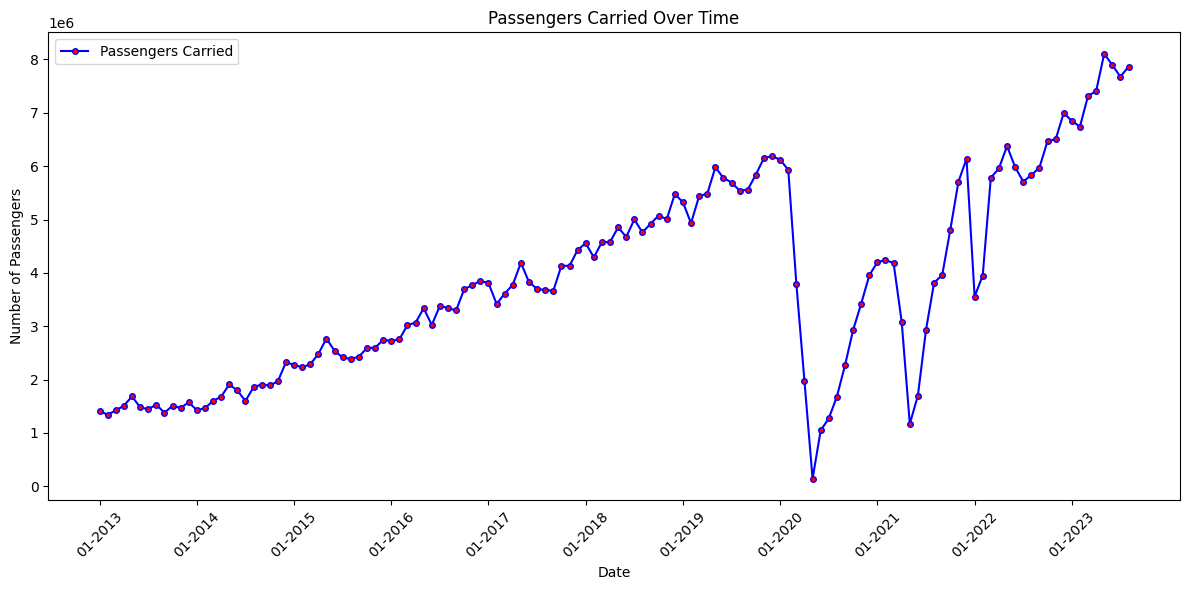

In [53]:
def plot_data(data):
    dates_str , passengers_carried = process_for_plot(data)

    plt.figure(figsize=(12, 6))
    plt.plot(dates_str, passengers_carried, label='Passengers Carried', color='blue',marker='o',ms=4,mfc='red')


    # Rotate x-axis labels for clarity
    plt.xticks(rotation=45)

    # Manually set the number of x-axis ticks to avoid crowding
    step = max(1, len(dates_str) // 10)
    plt.xticks(np.arange(0, len(dates_str), step), dates_str[::step])

    # Titles and labels
    plt.title('Passengers Carried Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Passengers')
    plt.legend()

    # Adjust layout to prevent label cut-off
    plt.tight_layout()

    # Save and display the plot
    plt.savefig('airtraffic.png')
    plt.show()

plot_data(data)

ADF Statistic: -6.410587
p-value: 0.000000
Critical Values:
	1%: -3.486
	5%: -2.886
	10%: -2.580
Stationary
1.8952005823801283e-08
Optimal d value is 1
ADF Statistic: -3.058652
p-value: 0.029768
Critical Values:
	1%: -3.489
	5%: -2.887
	10%: -2.580
Stationary
0.02976836749332001
Optimal d value is 2
ADF Statistic: -2.957096
p-value: 0.039100
Critical Values:
	1%: -3.489
	5%: -2.887
	10%: -2.580
Stationary
0.03910007131852567
Optimal d value is 3
ADF Statistic: -2.472581
p-value: 0.122289
Critical Values:
	1%: -3.490
	5%: -2.887
	10%: -2.581
Non-stationary
0.12228894981749555
ADF Statistic: -2.160535
p-value: 0.220880
Critical Values:
	1%: -3.490
	5%: -2.888
	10%: -2.581
Non-stationary
0.22087951963317298
ADF Statistic: -2.452017
p-value: 0.127590
Critical Values:
	1%: -3.492
	5%: -2.889
	10%: -2.581
Non-stationary
0.1275897929849345
ADF Statistic: -2.190317
p-value: 0.209779
Critical Values:
	1%: -3.493
	5%: -2.889
	10%: -2.581
Non-stationary
0.20977851164603867
ADF Statistic: -4.50219

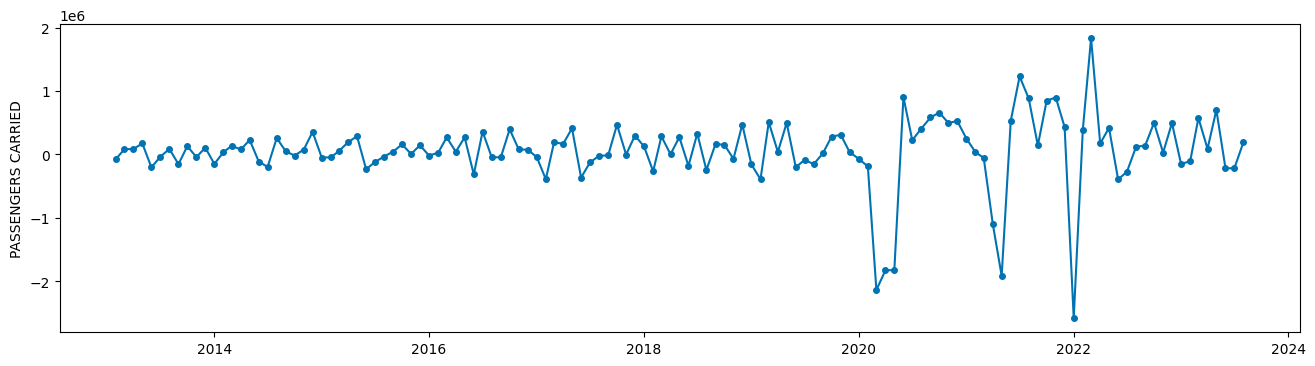

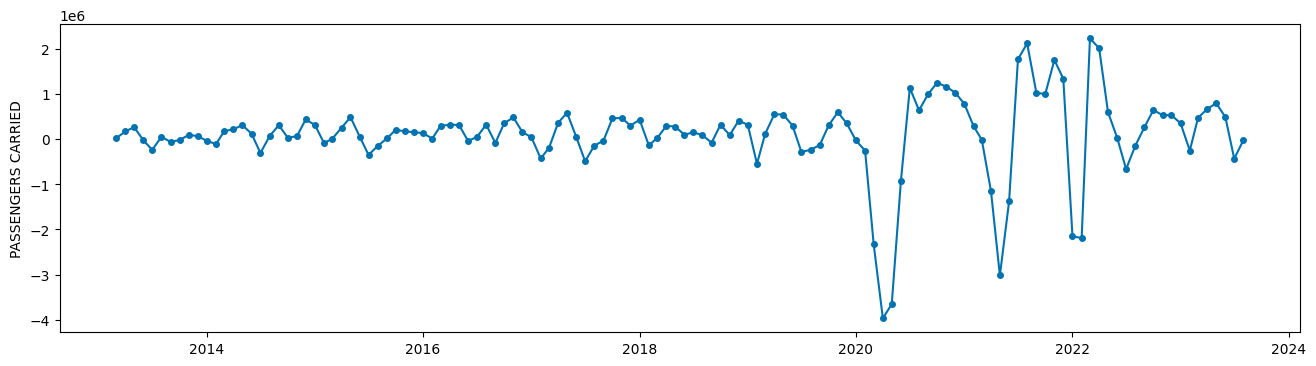

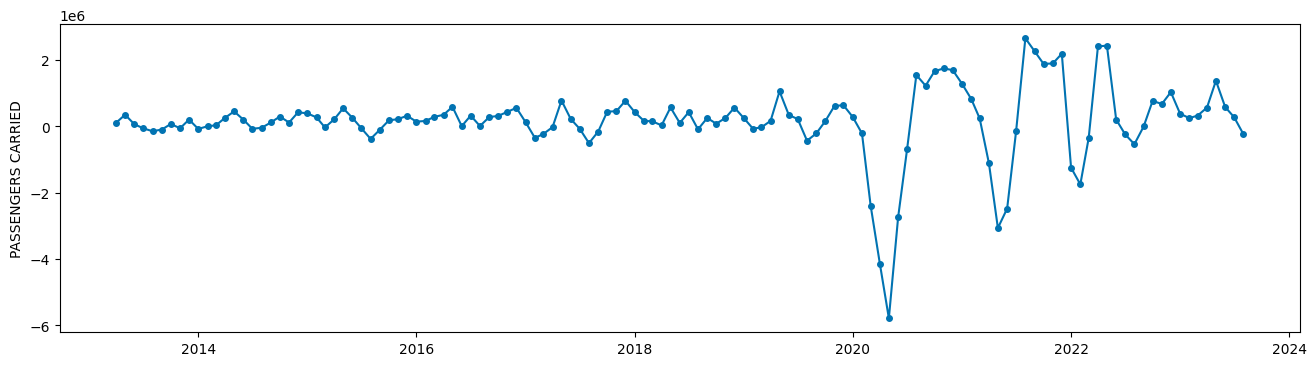

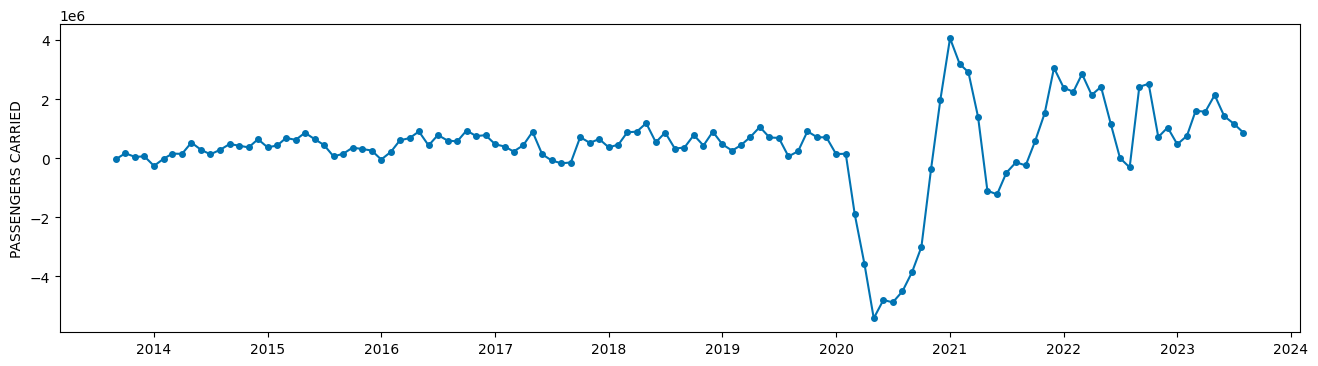

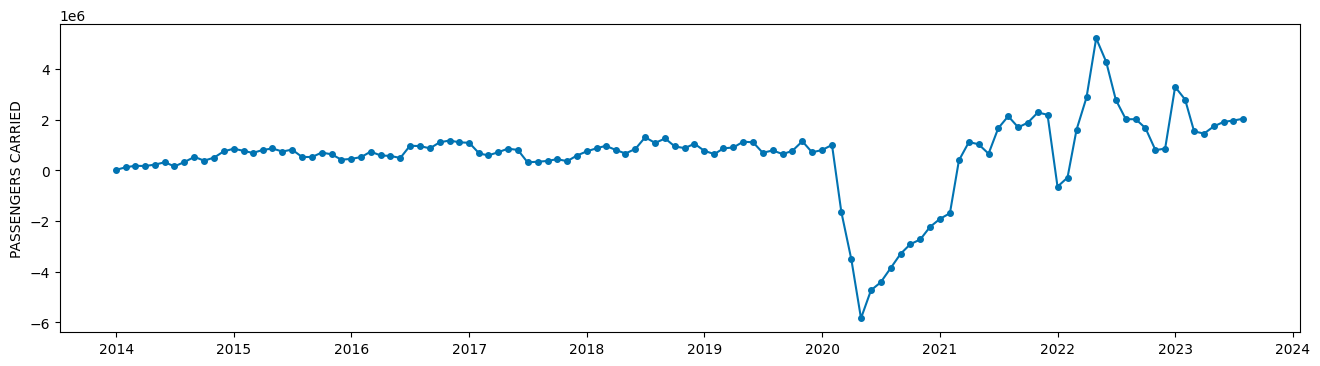

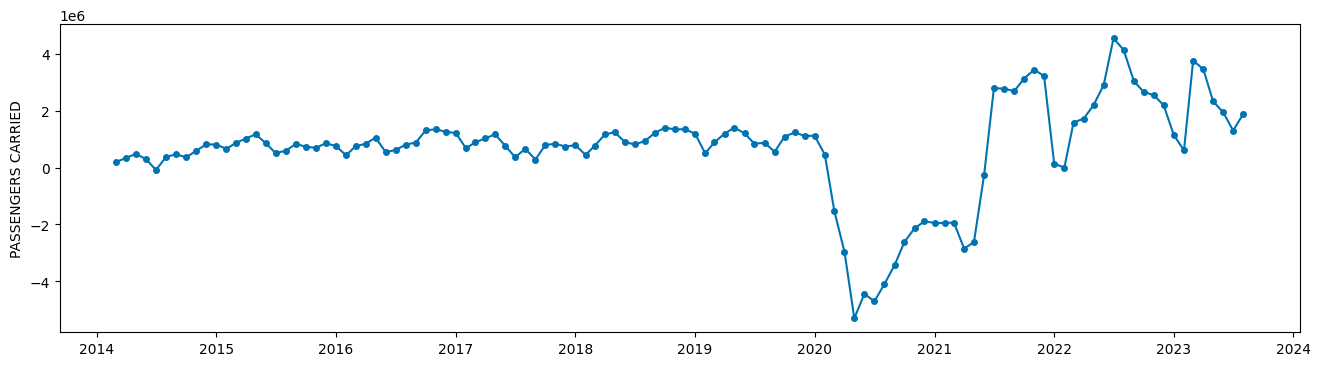

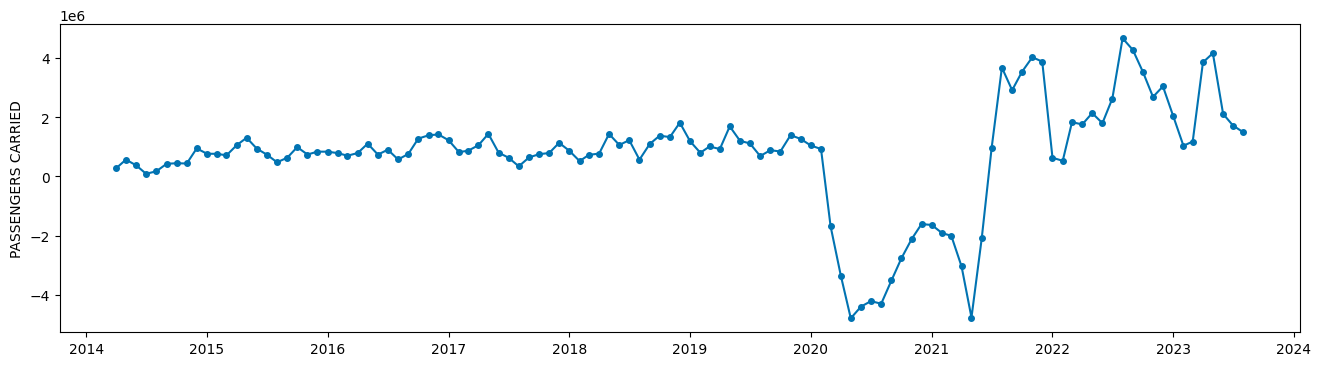

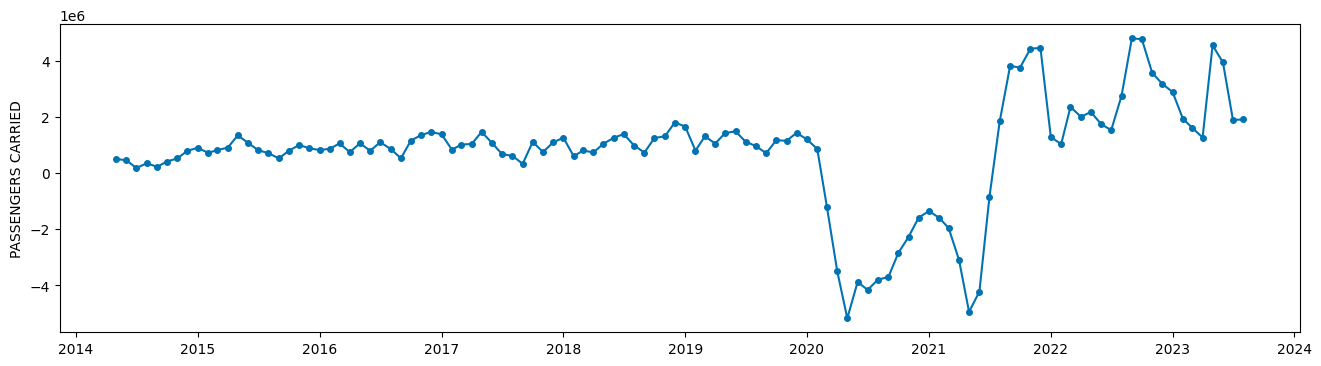

In [49]:
def plotting_diffrenced_data(data,d):
    Difier = Differencer(lags=d,na_handling="drop_na")
    diifference_data = Difier.fit_transform(data)
    p_values = check_stationary(diifference_data)
    return p_values , diifference_data

def optimal_d(data) :
    for i in range(1,30):
        p_value , diff_data = plotting_diffrenced_data(data,i)
        print(p_value)
        if p_value <= 0.05:
            print(f"Optimal d value is {i}")
            plot_series(diff_data)
            # plot_data(diff_data)

optimal_d(data)


In [38]:
# Plotting ACF and PACF 
def acf_pacf(data,lags=None) :
    return acf(data,nlags=lags) , pacf(data,nlags=lags)


In [39]:
def plot_acf_pacf(data,lags=None) : 
    fig , ax = plt.subplots(1,2,figsize=(10,5))
    acf_nlags , pacf_nlags = acf_pacf(data,lags)

    x_axis_acf = np.arange(0,acf_nlags.shape[0],1)
    x_axis_pacf = np.arange(0,pacf_nlags.shape[0],1)

    # Add markers at the top of ACF bars
    for i, value in enumerate(acf_nlags):
        ax[0].plot(i, value, 'bo')  # 'ro' means red circle markers

    ax[0].bar(x_axis_acf,acf_nlags,width=0.2)
    ax[0].grid(True)
    ax[0].set_xlabel("lags")
    ax[0].set_ylabel("ACF")
    ax[0].set_title('Autocorrelation Function (ACF)')

    # Add markers at the top of ACF bars
    for i, value in enumerate(pacf_nlags):
        ax[1].plot(i, value, 'bo')  # 'ro' means red circle markers

    ax[1].bar(x_axis_pacf,pacf_nlags,width=0.2)
    ax[1].grid(True)
    ax[1].set_xlabel("lags")
    ax[1].set_ylabel("PACF")
    ax[1].set_title('Partial Autocorrelation Function (PACF)')

    plt.show()

    return acf_nlags , pacf_nlags

ADF Statistic: -2.915358
p-value: 0.043591
Critical Values:
	1%: -3.491
	5%: -2.888
	10%: -2.581
Stationary


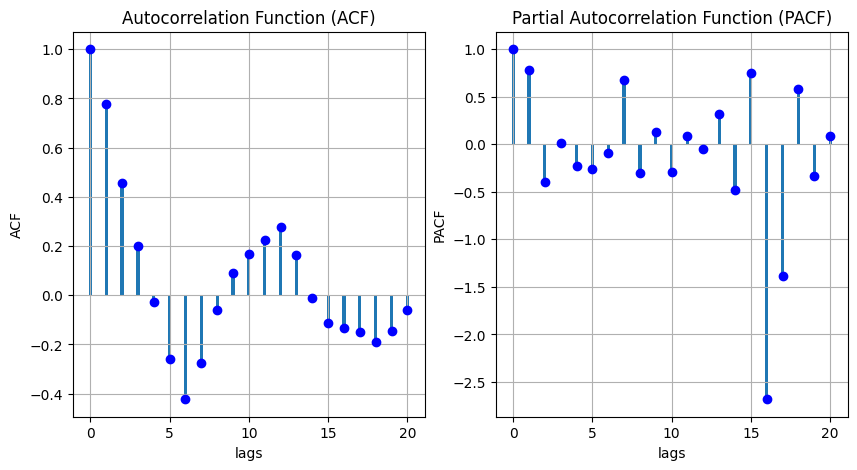

ACF for 20 lags = [ 1.          0.77807395  0.45635261  0.19880999 -0.02757801 -0.25820757
 -0.42259166 -0.27720987 -0.05862764  0.08949737  0.16859933  0.22622827
  0.27620516  0.16250248 -0.01022175 -0.11359671 -0.13179514 -0.14987799
 -0.19127667 -0.14594303 -0.05801142]
PACF for 20 lags = [ 1.          0.7845579  -0.39407268  0.01700237 -0.23011532 -0.25759909
 -0.09479485  0.67724841 -0.29977085  0.12793442 -0.29318945  0.09217408
 -0.04563326  0.3200164  -0.48337837  0.74666712 -2.68170713 -1.38889604
  0.58568162 -0.33765753  0.08645933]


In [40]:
lags = 20
_, new_data = plotting_diffrenced_data(data,6)
acf_nlags , pacf_nlags = plot_acf_pacf(new_data,lags)
print(f"ACF for {lags} lags = {acf_nlags}")
print(f"PACF for {lags} lags = {pacf_nlags}")

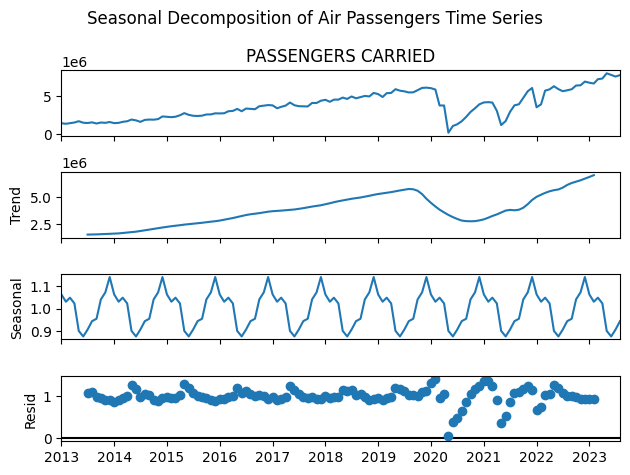

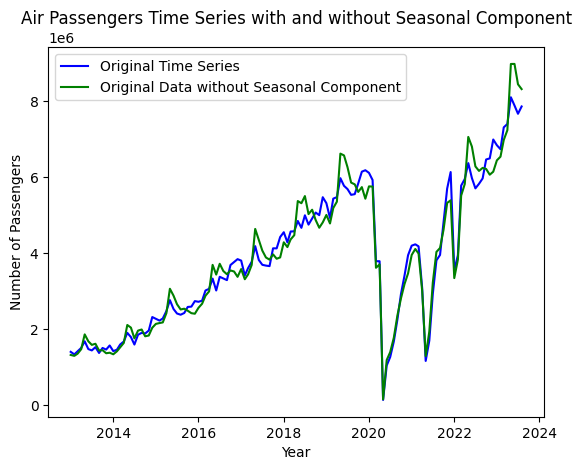

In [43]:
"""
This Plot demonstrates that there is no significant sesonality in the data 
"""


# Ensure the 'DATE' column is a DatetimeIndex
data.index = pd.to_datetime(data.index)

data['PASSENGERS CARRIED'] = data['PASSENGERS CARRIED'].ffill()
# Set the frequency to 'MS' (Month Start) since it's monthly data
data = data.asfreq('MS')

# Decompose the time series into trend, seasonal, and residual components
result = seasonal_decompose(data['PASSENGERS CARRIED'], model='multiplicative')

# Plot the results
result.plot()
plt.suptitle('Seasonal Decomposition of Air Passengers Time Series')
plt.tight_layout()
plt.show()

data_without_seasonal = data['PASSENGERS CARRIED'] / result.seasonal
# Plot the original data without the seasonal component
plt.plot(data, label='Original Time Series', color='blue')
plt.plot(data_without_seasonal, label='Original Data without Seasonal Component', color='green')
plt.title('Air Passengers Time Series with and without Seasonal Component')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

In [99]:
def MAE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [101]:
def fit_arima_model(data, p, d, q):
    
# Fit the ARIMA model and visualize the forecast
p = 4
d = 6 
q = 3
mae, mape = fit_arima_model(data, p, d, q)
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")


C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  103
Model:               SARIMAX(4, 6, 3)   Log Likelihood               -1482.274
Date:                Mon, 21 Oct 2024   AIC                           2982.547
Time:                        11:47:47   BIC                           3005.720
Sample:                    01-01-2013   HQIC                          2991.917
                         - 07-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.311e+04   5.07e+04      0.653      0.514   -6.63e+04    1.33e+05
ar.L1         -2.7059      0.206    -13.160      0.000      -3.109      -2.303
ar.L2         -2.9623      0.491     -6.032      0.0

AttributeError: 'pandas._libs.tslibs.offsets.MonthBegin' object has no attribute '_period_dtype_code'

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='PASSENGERS CARRIED'>)

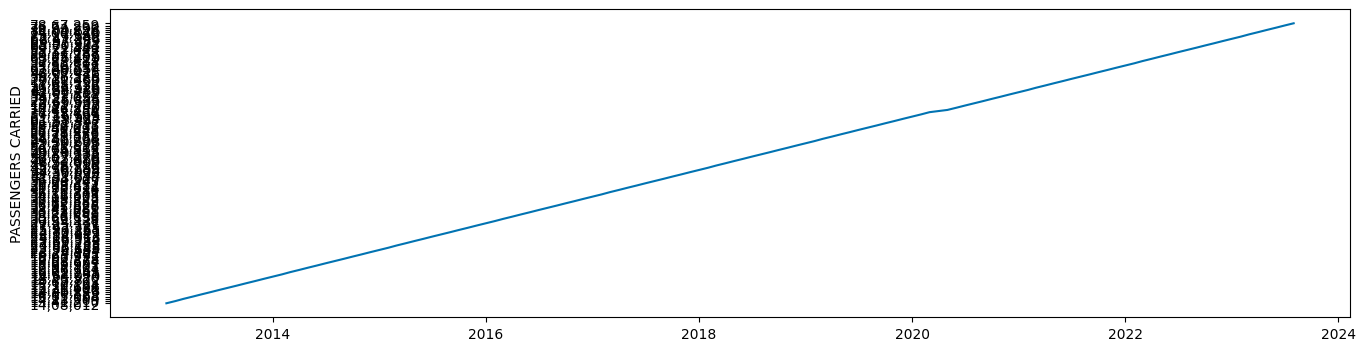

In [107]:
plot_series(data,markers=' ')